# Analysing CIA Factbook Data Using SQL

## Introduction

In this project, we will use SQL to analyse data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/). The Factbook contains information such as the global population, the annual population growth rate, and the total land and water area on the planet.

In [1]:
!conda install -yc conda-forge ipython-sql

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [3]:
%%sql
SELECT * 
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


## Overview of the Data

Let's run a query to explore the first five rows of the `facts` table in the database.

In [4]:
%%sql
SELECT *
  FROM facts
 LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:

* `name` — the name of the country.
* `area`— the country's total area (both land and water).
* `area_land` — the country's land area in square kilometers.
* `area_water` — the country's waterarea in square kilometers.
* `population` — the country's population.
* `population_growth`— the country's population growth as a percentage.
* `birth_rate` — the country's birth rate, or the number of births per year per 1,000 people.
* `death_rate` — the country's death rate, or the number of death per year per 1,000 people.

Let's start by calculating some summary statistics and look for any outlier countries.

## Summary Statistics

In [6]:
%%sql
SELECT MIN(population) AS min_population,
       MAX(population) AS max_population,
       MIN(population_growth) AS min_population_growth,
       MAX(population_growth) AS max_population_growth
  FROM facts;

 * sqlite:///factbook.db
Done.


min_population,max_population,min_population_growth,max_population_growth
0,7256490011,0.0,4.02


## Exploring Outliers

There are a couple of interesting things in the summary statistics above:

* There's a country with a population of 0.
* There's a country with a poopulation of 7256490011 (or more than 7.2 billion people).

Let's use subqueries to zoom in on just these countries.

In [7]:
%%sql
SELECT *
  FROM facts
 WHERE population = (SELECT MIN(population)
                       FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


The country with a population of 0 is Antarctica, which matches what is said on the Factpage about the country:

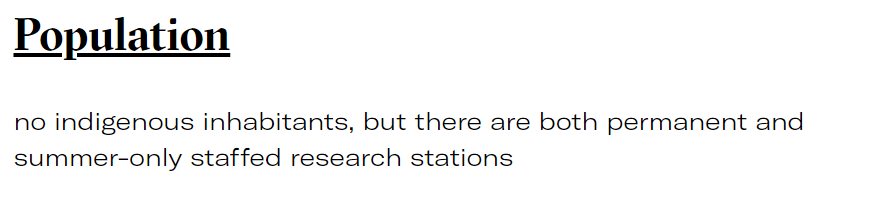

In [8]:
%%sql
SELECT *
  FROM facts
 WHERE population = (SELECT MAX(population)
                       FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


We can see here that the country with the population of over 7 billion is not a country, it is actually an entry for the entire world.

## Exploring Average Population and Area

Now that we know there's an entry for the world, we can recalculate our summary statistics with that row excluded. 

Let's also calculate the average population and area for countries.

In [9]:
%%sql
SELECT MIN(population) AS min_population,
       MAX(population) AS max_population,
       MIN(population_growth) AS min_population_growth,
       MAX(population_growth) AS max_population_growth
  FROM facts
 WHERE name != 'World';

 * sqlite:///factbook.db
Done.


min_population,max_population,min_population_growth,max_population_growth
0,1367485388,0.0,4.02


In [14]:
%%sql
SELECT AVG(population) AS avg_population,
       AVG(area) AS avg_area
  FROM facts
 WHERE name != 'World';

 * sqlite:///factbook.db
Done.


avg_population,avg_area
32242666.56846473,555093.546184739


We can see that the average population is around 32 million and the average area is around 550 thousand square kilometers.

## Finding Densely Populated Countries

Now we know the averages for population and area, we can calculate which countries are densely populated by identifying those with the following:

* Above-average values for population
* Below-average values for area

In [15]:
%%sql
SELECT *
  FROM facts
 WHERE population > (SELECT AVG(population)
                       FROM facts
                      WHERE name != 'World')
   AND area < (SELECT AVG(area)
                 FROM facts
                WHERE name != 'World');

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
80,iz,Iraq,438317,437367,950,37056169,2.93,31.45,3.77,1.62
83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.1
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.0
120,mo,Morocco,446550,446300,250,33322699,1.0,18.2,4.81,3.36
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
139,pl,Poland,312685,304255,8430,38562189,0.09,9.74,10.19,0.46
163,sp,Spain,505370,498980,6390,48146134,0.89,9.64,9.04,8.31


We can see a number of countries that are generally considered to be densely populated, such as Bangladesh and South Korea. So, we can be confident that our query worked as intended.